# Slicing a turbulent box for 3D printing

In this notebook, we will explain how to get from a 3D density distribution to a stack of images that can get sent to polyjet 3D printing.

In [1]:
from pathlib import Path
import imageio

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


import  astro3d
from astro3d.image_stack import makeslice, process

plt.style.use([{'image.cmap':'gray_r'}])

Read data file

In [2]:
f = np.load(astro3d.get_data('turbulentbox.npy'))
data = f.copy()
del f

## Normalization

The data set needs to be normalized to values between 0 and 1. In this case, we want to use a logarithmic norm. We find the largest magnitude of the data values and define a logarithmic norm from 1/100th of the maximum to the maximum value.

In [3]:
vmax = data.max()
norm = LogNorm(1e-2 * vmax, vmax, clip=True)

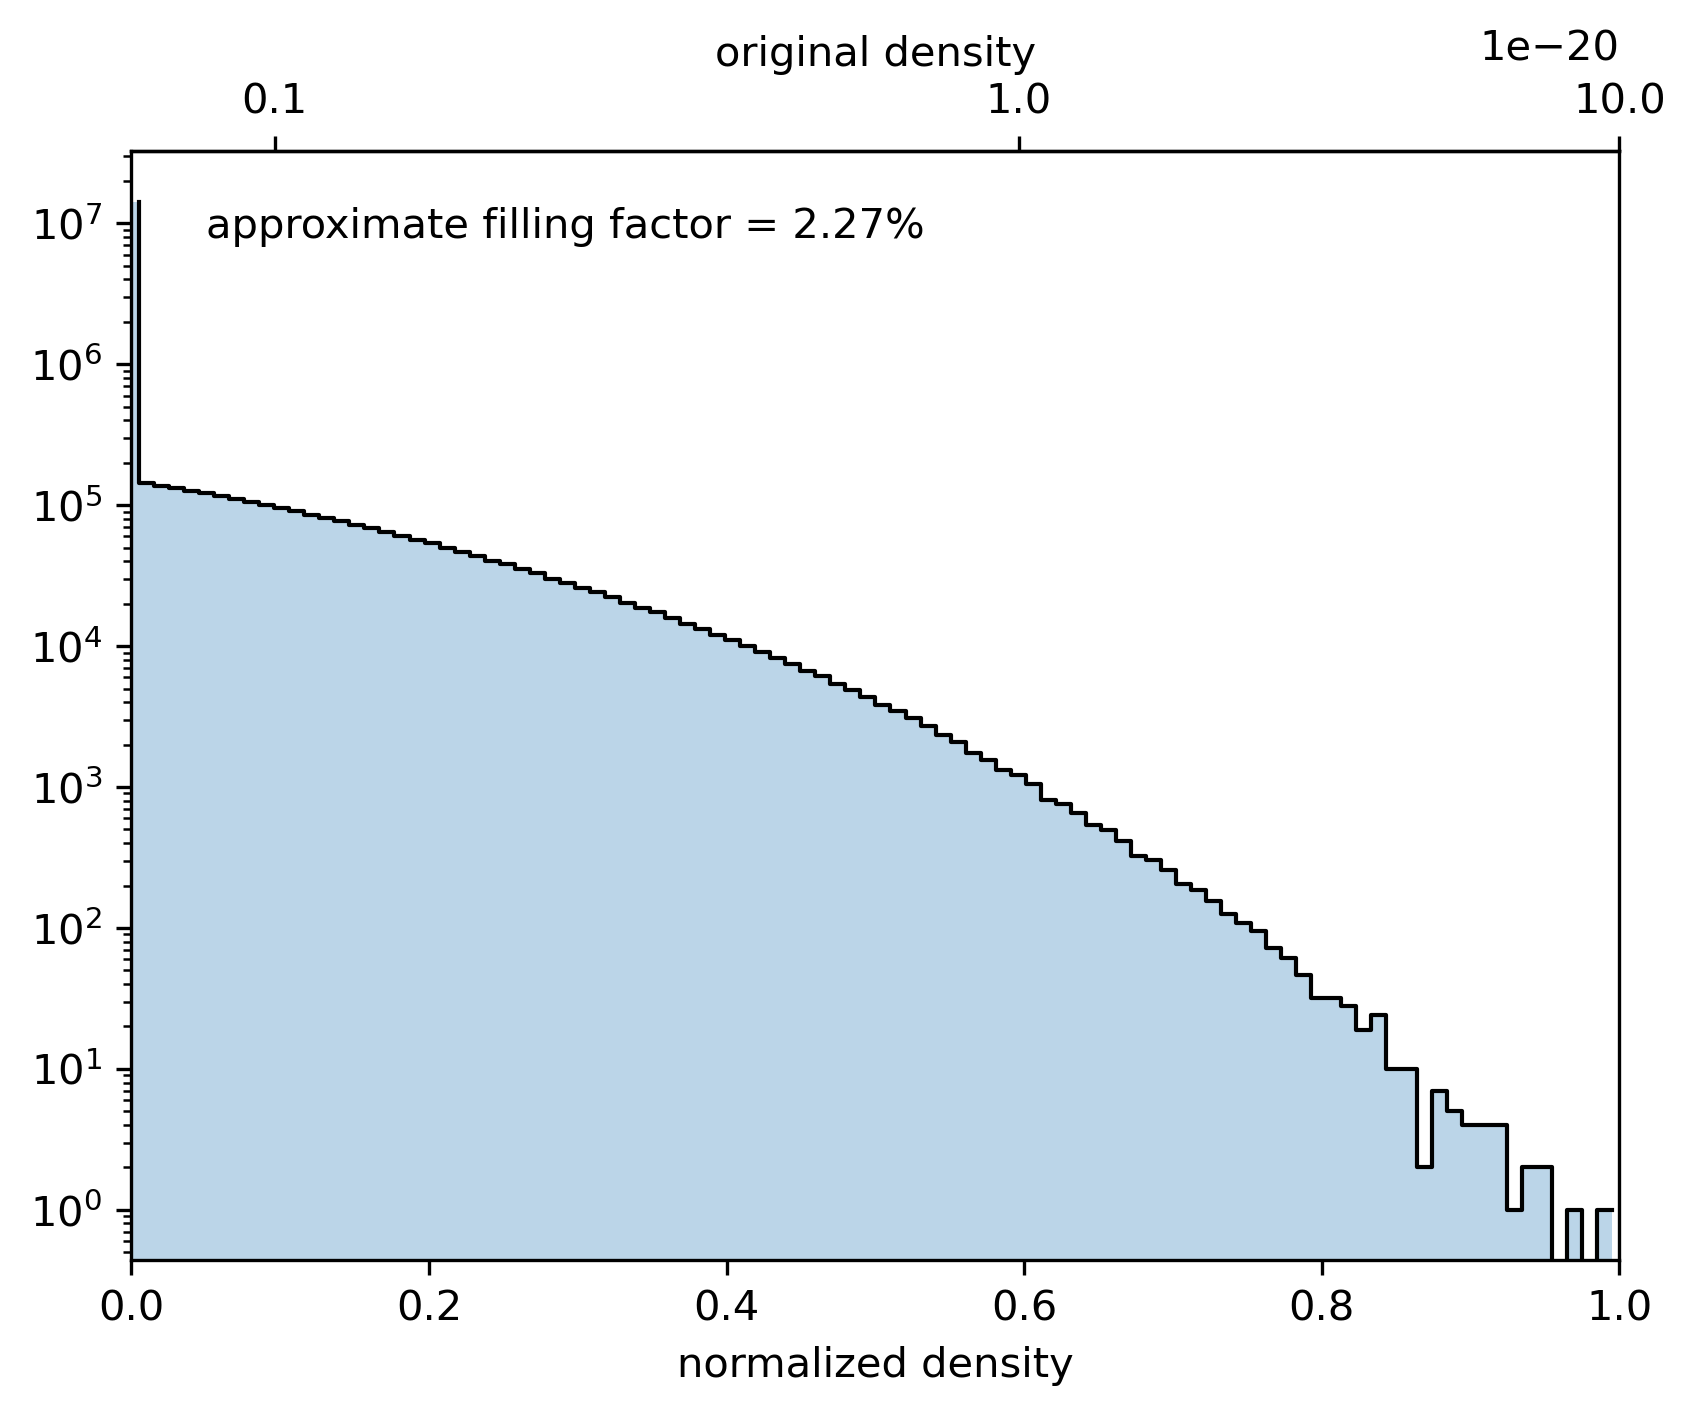

In [4]:
astro3d.image_stack.show_histogram(data, norm)

## Example plot

We apply the norm to the data slice and show the image on gray scale and dithered:

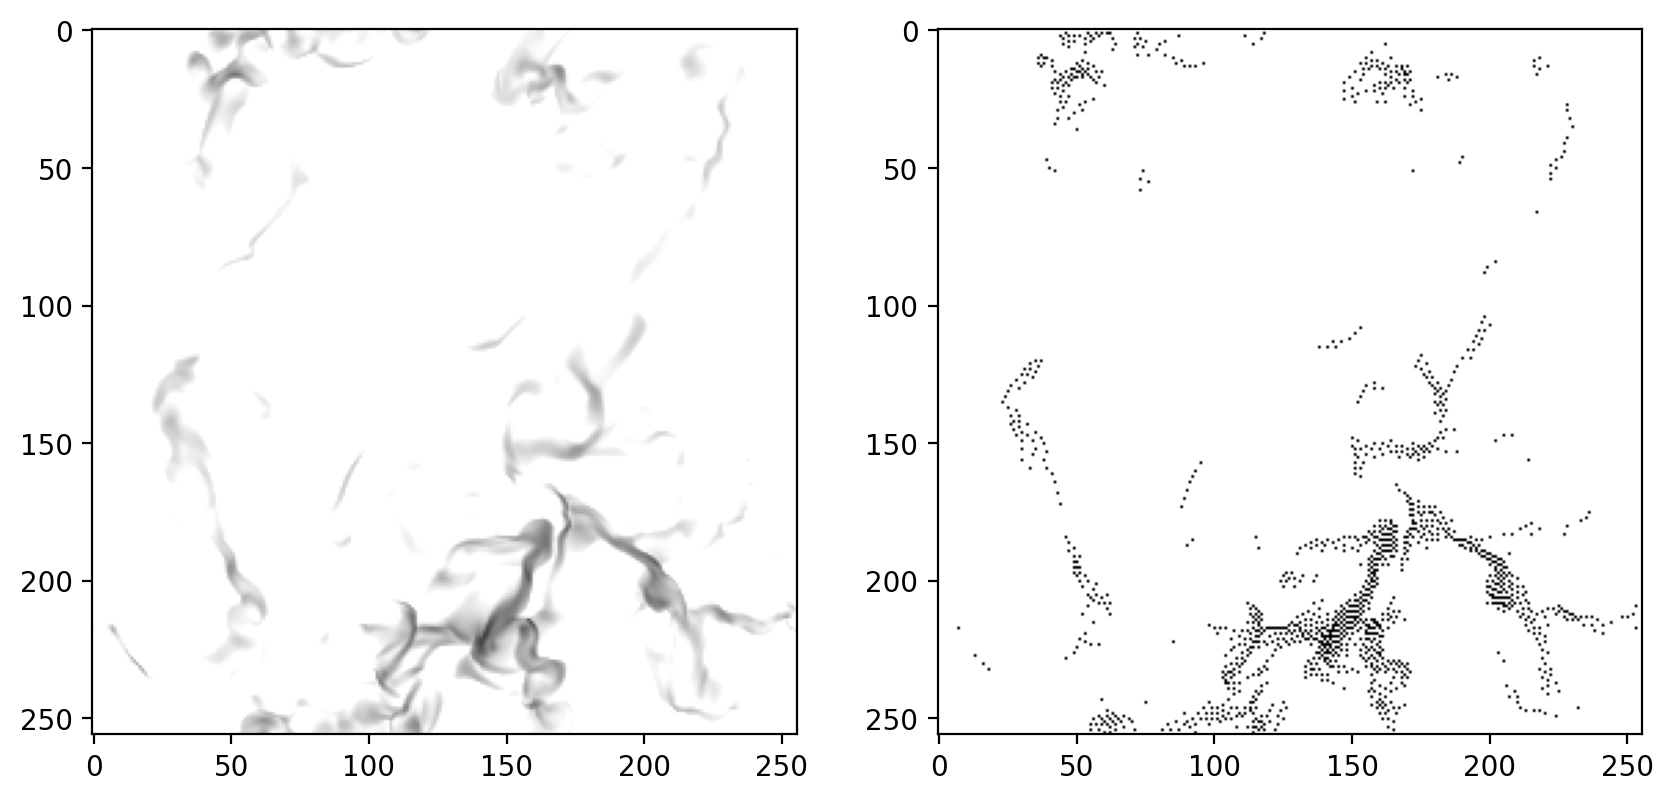

In [5]:
# Select which slice to plot
i = 0

# apply the norm
d_0 = np.array(norm(data[:, :, i]))

# plot it and it's dithered version
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(d_0, vmin=0, vmax=1)
ax[1].imshow(astro3d.fmodule.dither(d_0), vmin=0, vmax=1);

Same, but interpolated to higher resolution

## Upscale the data

We can see that the dithering above is working, but while the left image can display grayscale, the right image needs to emulate this with black and white points. To achieve a visually similar result, we would need a higher pixel count in the dithered image. Thankfully, we will need much more pixels for 3D printing anyhow as we will see next.

### Coordinates & aspect ratios

these are the original "coordinates" of the pixels, if we start counting from 0:

In [6]:
x = np.linspace(0, data.shape[0] - 1, data.shape[0])
y = np.linspace(0, data.shape[1] - 1, data.shape[1])
z = np.linspace(0, data.shape[2] - 1, data.shape[2])

To provide more pixels than the original resolution, we need to upscale/interpolate the data. We need to do this in 3 dimensions as the printer dictates the resolution in each dimension. For example the dataset is $256^3$, but 256 points would only correspond to a printed length of 0.7 to 2 cm, depending on the printer resolution.

So to upscale the data, we need to know the resolution in each direction and as need an interpolation function to map the 3D data onto the printer grid.

We start with defining an interpolation function:

In [7]:
def f_interp(coords):
    return astro3d.fmodule.interpolate(x, y, z, data, coords)

Next, we need to look up the printer settings. Depending on the model, the (in-plane) x and y resolution is 600x300 DPI or 600x600 DPI. This distinction is crucial because printing a square image on 600x600 DPI would result also in a printed square, but on 600x300 DPI we would get a 1:2 aspect ratio.

In addition to that, we need to find out what layer thickness values the printer supports and pick one of them. Here we will proceed with a 600x300 DPI printer resolution and a layer thickness of 27 micron.

Furthermore, we want to print our data into a cube of 5 cm on each side:

In [8]:
height = 5 # this should be the total height of the printed cube in cm

# these are the values for the J850 Prime
#dpi_x = 600
#dpi_y = 600
#dpi_z = 940  # 0.027 mm layer thickness

# these are the values used in alphacams TEILEFABRIK, where we ordered some of our prints
dpi_x = 600
dpi_y = 300
dpi_z = 940 # 0.027 mm layer thickness = 2.54 / dpi_z

Now we define the new grids which are in the same coordinate space as our data (0...254), but with finer grid size to match the printer resolution: the number of points is the physical dimension along one direction divided by the layer thickness in that direction:

\begin{align}
n _ i &= int\left(\frac{\mathrm{length} _ i}{\mathrm{layer~thickness} _ i}\right)\\
\mathrm{layer~thickness}_i &= \frac{2.54 cm}{\mathrm{DPI}_i}
\end{align}

Apparently the image dimension should be even, so we add a single pixel if it isn't.

In [9]:
n_z = int(height * dpi_z / 2.54)
n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x % 2 # add 1 to make it even if it isn't
n_y += n_y % 2 # add 1 to make it even if it isn't

# these are our new grids
x2 = np.linspace(0, data.shape[0] - 1, n_x)
y2 = np.linspace(0, data.shape[1] - 1, n_y)
z2 = np.linspace(0, data.shape[2] - 1, n_z)

coords = (x2, y2, z2)

### Iteration

We iterate over the entire 1850 layers and store the images in the path set by `output_dir`.

In [10]:
output_dir = 'slices_turbulent_box_example'

Prepare output folder

In [11]:
path = Path(astro3d.get_output()) / output_dir

if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

directory exists, deleting old files


Next, we will plug the new grid into a format that we can pass to our interpolation function. As the interpolated data will be quite large (in this example `1180 x 590 x 1850`), we will do the interpolation one layer at a time. `coords` will stay mostly the same, we will just update the z-coordinate, so the height at which we comppute the layer.

First, select which layer index in the new z-grid to process for this example:

In [12]:
iz = 0

This cell does the same as `makeslice`: interpolates one layer, creates and dithers the image and writes it to file

In [13]:
coords2 = np.array(np.meshgrid(x2, y2, z2[iz])).squeeze().reshape(3, -1).T

# interpolate: note that we transpose as this is how the image will be safed
new_layer = f_interp(coords2).reshape(len(y2), len(x2))

# normalize, convert to grayscale image
layer_norm = np.array(norm(new_layer))
layer_dither = astro3d.fmodule.dither_colors(layer_norm[:,:, None])

# save as png
imageio.imwrite(path / f'slice_{iz:04d}.png', np.uint8(255 - 255 * layer_dither))

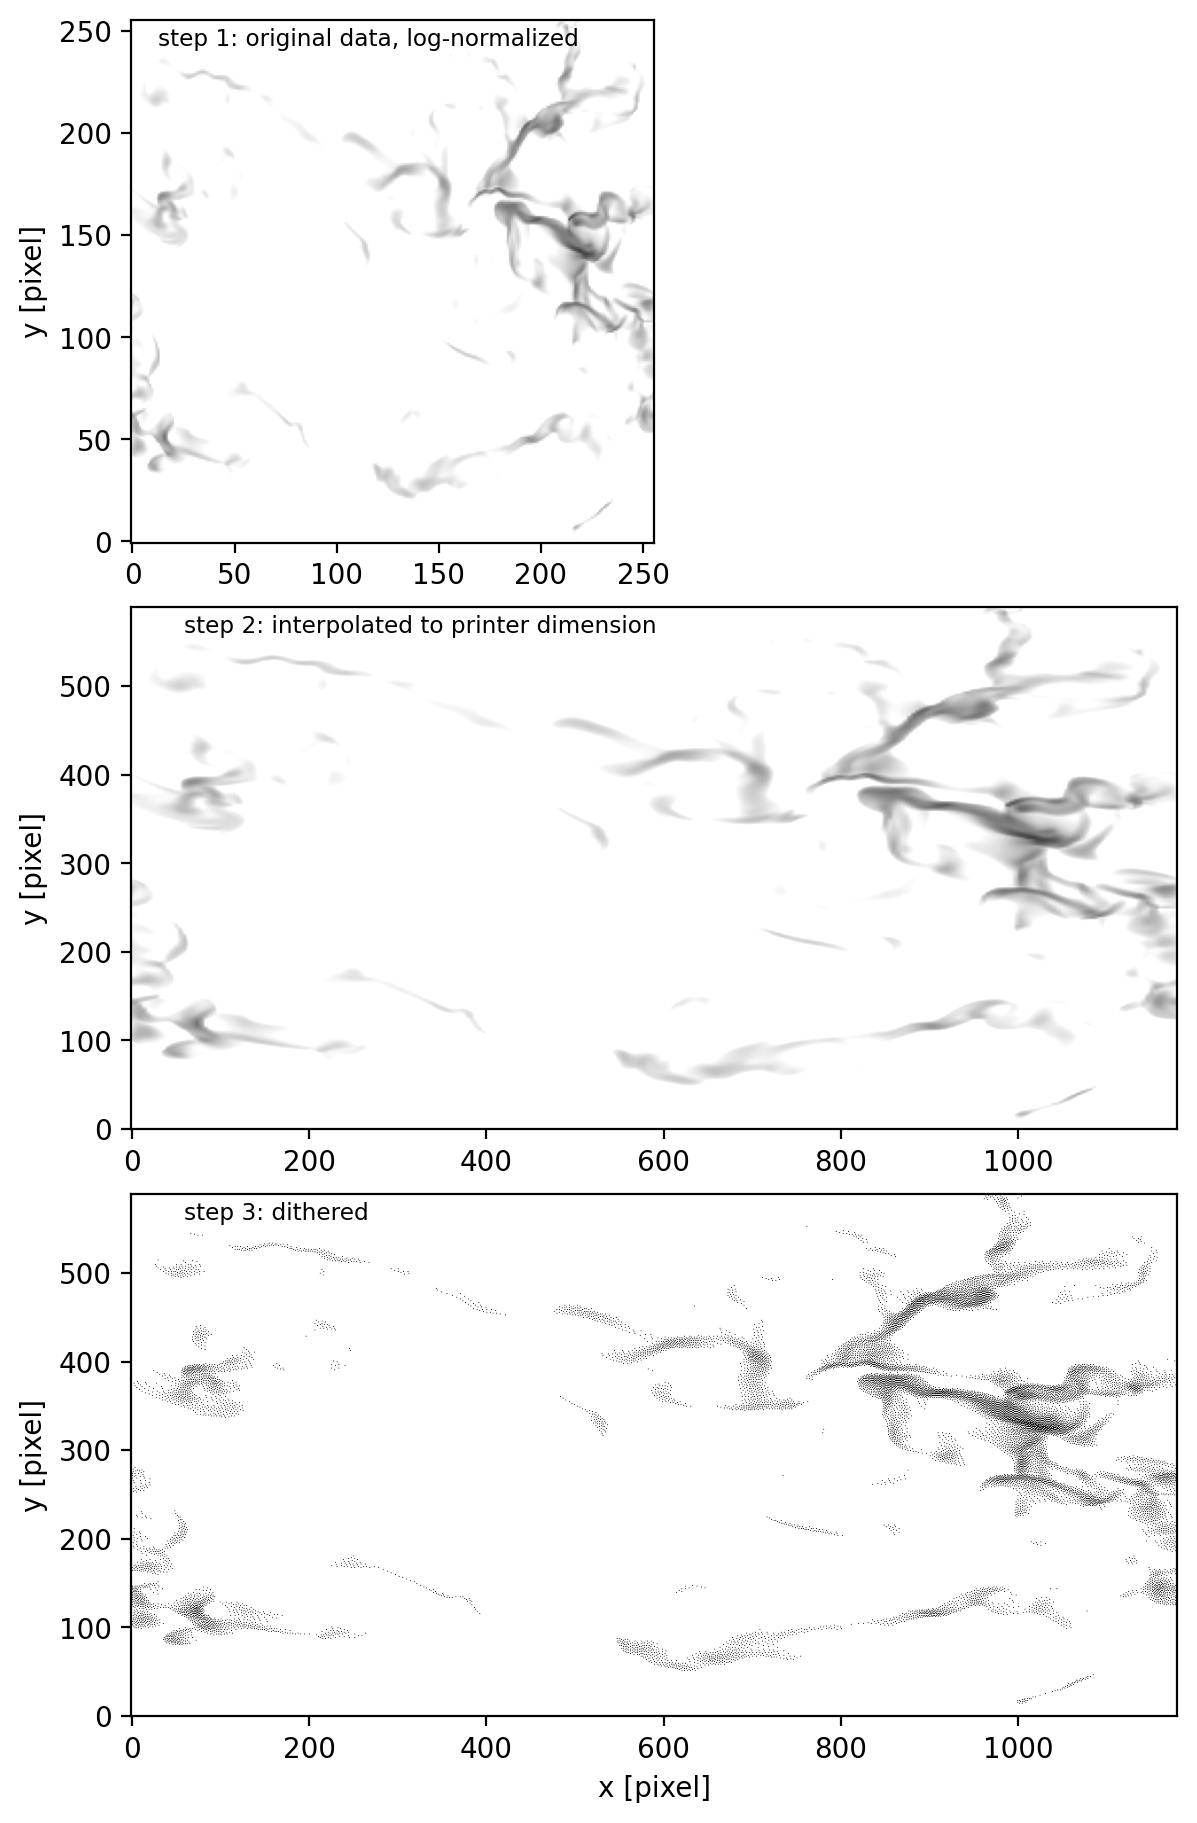

In [14]:
f, axs = plt.subplots(3, 1, dpi=100, figsize=(2*3, 3*3), constrained_layout=True)
axs[0].imshow(norm(data[:, :, z.searchsorted(z2[iz])]).T, vmin=0, vmax=1, origin='lower')
axs[1].imshow(layer_norm, vmin=0, vmax=1, origin='lower')
axs[2].imshow(layer_dither, vmin=0, vmax=1, origin='lower')
axs[0].text(0.05, 0.95, 'step 1: original data, log-normalized', fontsize='small', transform=axs[0].transAxes)
axs[1].text(0.05, 0.95, 'step 2: interpolated to printer dimension', fontsize='small', transform=axs[1].transAxes)
axs[2].text(0.05, 0.95, 'step 3: dithered', fontsize='small', transform=axs[2].transAxes)

for ax in axs:
    ax.set_ylabel('y [pixel]')
    ax.set_anchor('W')
axs[-1].set_xlabel('x [pixel]');

this is the same result using `makeslice_color`:

In [15]:
makeslice(iz, z2, f_interp, coords, norm, path);

Let's check what this image looks like:

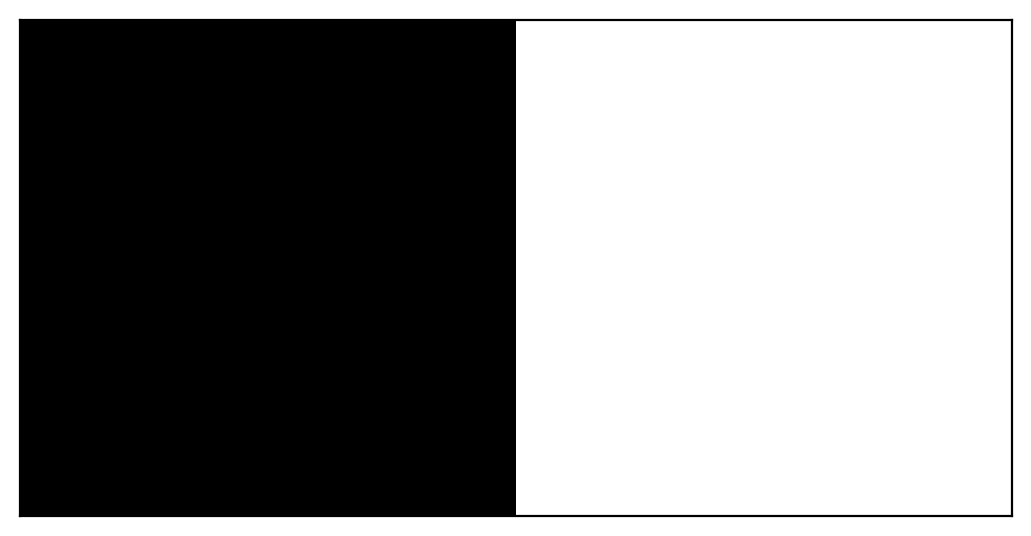

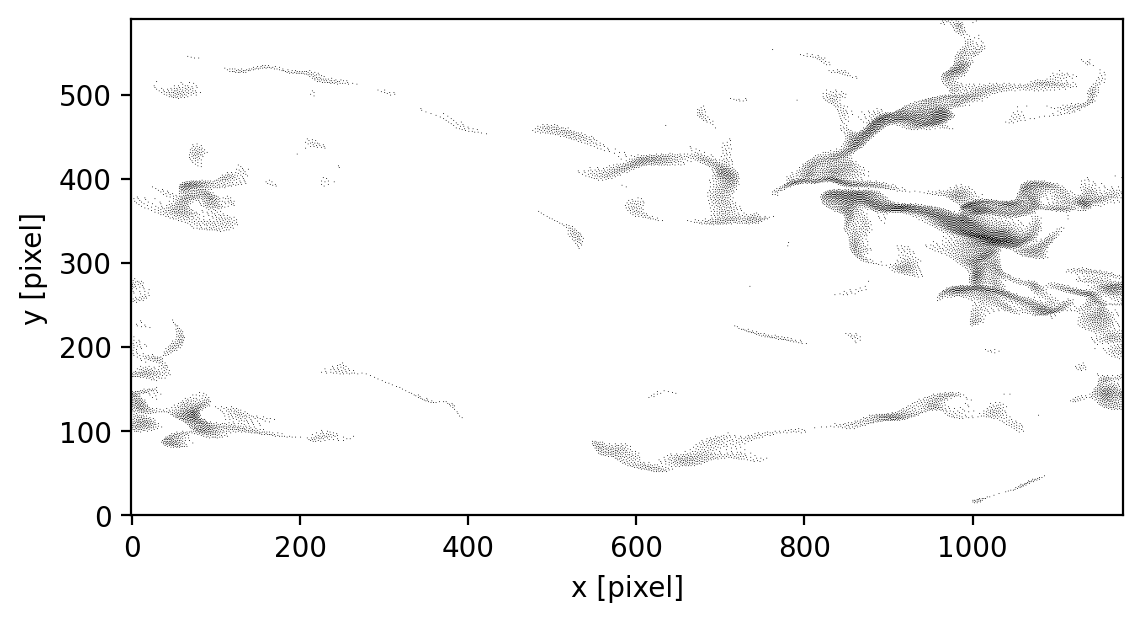

In [16]:
im = imageio.v2.imread(path / f'slice_{iz:04d}.png')
colors = astro3d.image_stack.check_colors(im)

plt.imshow([colors]).axes.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)

f, ax = plt.subplots()
ax.imshow(im, vmin=0, vmax=254, origin='lower')
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]');

## Batch processing

all of the above can also be done in a loop with `process`:
normalizing with the given norm, up-scaling and saving to images. We'll just do this same one here by specifying the `iz` keyword.

In [17]:
iz = np.arange(int(0.1 * dpi_z / 2.54)) # just the first millimeter

In [18]:
process(data,
        height=height, dpi_x=dpi_x, dpi_y=dpi_y, dpi_z=dpi_z,
        output_dir=path,
        norm=norm,
        iz=iz # comment this out to run the full stack
       )

original data: 256 x 256 x 256
interpoation to: 1180 x 590 x 1850
print size: 5.00 x 5.00 x 5.00 cm
saving into /Users/birnstiel/CODES/astro3Dprinting/astro3d/output/slices_turbulent_box_example
directory exists, deleting old files
only printing 0.10 cm of it


  0%|          | 0/37 [00:00<?, ?it/s]